In [7]:
import pandas as pd
import numpy as np
import re 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
reviews=pd.read_csv("C:/Users/areem/cleaned_reviews_w_lang.csv")

In [9]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,language
0,1419,38924112,2015-07-19,11308465,Marcela,Having the opportunity of arriving to Alexandr...,Having the opportunity of arriving to Alexandr...,en
1,1419,44791978,2015-08-29,9580285,Marco,We have no enough words to describe how beauty...,We have no enough words to describe how beauty...,en
2,1419,45957133,2015-09-07,38394721,Andrea,The listing was exceptional and an even better...,The listing was exceptional and an even better...,en
3,1419,67295154,2016-03-28,3515044,Shaun,Alexandra's home was amazing and in such a nea...,Alexandra's home was amazing and in such a nea...,en
4,1419,177702208,2017-08-03,13987100,Kate,Beautiful home. Very comfortable and clean. Pe...,Beautiful home. Very comfortable and clean. Pe...,en


In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459355 entries, 0 to 459354
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   listing_id        459355 non-null  int64 
 1   id                459355 non-null  int64 
 2   date              459355 non-null  object
 3   reviewer_id       459355 non-null  int64 
 4   reviewer_name     459355 non-null  object
 5   comments          459355 non-null  object
 6   cleaned_comments  459355 non-null  object
 7   language          459355 non-null  object
dtypes: int64(3), object(5)
memory usage: 28.0+ MB


Text preprocessing before sentiment analysis

In [11]:
# CLEAN TEXT:

## Function to remove <br/> tags
def remove_br_tags(text):
    # Check if text is not NaN
    if pd.notna(text):
        return re.sub(r'<br\s*/?>', ' ', text)  # Replace <br/> with space
    return text

# Apply the function to each comment to remove <br/> tags
reviews['cleaned_comments'] = reviews['cleaned_comments'].apply(remove_br_tags)

# Function to remove URLs
def remove_urls(text):
    # This pattern matches most types of URLs
    url_pattern = r'https?://[^\s]+|www\.[^\s]+|http?://[^\s]+'
    # Replace found URLs with an empty string
    return re.sub(url_pattern, '', text)

# Apply the function to remove URLs from each comment
reviews['cleaned_comments'] = reviews['cleaned_comments'].apply(remove_urls)

# lets remove those additonal whitespaces now
reviews['cleaned_comments'] = reviews['cleaned_comments'].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip())

# Function to remove special characters (not all)
def remove_min_special_characters(text):
    char_pattern = re.compile(r'[^\w\s\?\!\.,\']')
    return re.sub(char_pattern, '', text)

# Apply special character function
reviews['cleaned_comments'] = reviews['cleaned_comments'].apply(remove_min_special_characters)    

In [12]:
# check if text preprocessing steps saved in previous work

import re
from collections import defaultdict

# Function to find HTML tags for inspection
def find_html_tags(text_series):
    tag_counts = defaultdict(int)
    pattern = re.compile(r'<[^>]+>')
    for text in text_series.dropna():
        found_tags = pattern.findall(text)
        for tag in found_tags:
            tag_counts[tag] += 1
    return sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# Inspect HTML tags
html_tags = find_html_tags(reviews['cleaned_comments']) #!!! THIS WAS JUST reviews['comments'] -SO MAYBE TEXT PREPROCESSING WORKED AND I CHECKED WRONG!!!!
print("HTML tags found:", html_tags)


HTML tags found: []


In [83]:
# More checks to ensure preprocessing was successfully saved

import re

# Function to search for regex patterns in text and return issues found
def find_pattern_issues(text_series, pattern):
    issues = [text for text in text_series.dropna() if re.search(pattern, text)]
    return issues

# Implement the checks with the defined function
pattern_whitespace = re.compile(r'\s{2,}|\t|\n')
whitespace_issues = find_pattern_issues(reviews['cleaned_comments'], pattern_whitespace)

pattern_non_printable = re.compile(r'[^\x20-\x7E]')
non_printable_issues = find_pattern_issues(reviews['cleaned_comments'], pattern_non_printable)

pattern_punctuation = re.compile(r'[!@#$%^&*()_+=\[\]{}/?.,;:\'"`~\\|-]')
punctuation_issues = find_pattern_issues(reviews['cleaned_comments'], pattern_punctuation)

pattern_emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
emoji_issues = find_pattern_issues(reviews['cleaned_comments'], pattern_emoji)

# For uppercase words, modify the check as it's not suitable for the find_pattern_issues function
uppercase_words = [text for text in reviews['cleaned_comments'].dropna() if any(word.isupper() for word in text.split())]

pattern_numbers = re.compile(r'\d+')
number_issues = find_pattern_issues(reviews['cleaned_comments'], pattern_numbers)

# Now print or inspect the issues found
print(f"Whitespace issues found: {len(whitespace_issues)} examples")
print(f"Non-printable character issues found: {len(non_printable_issues)} examples")
print(f"Punctuation issues found: {len(punctuation_issues)} examples")
print(f"Emoji issues found: {len(emoji_issues)} examples")
print(f"Uppercase words found in: {len(uppercase_words)} comments")
print(f"Number/date issues found: {len(number_issues)} examples")

Whitespace issues found: 40803 examples
Non-printable character issues found: 2169 examples
Punctuation issues found: 435294 examples
Emoji issues found: 0 examples
Uppercase words found in: 163393 comments
Number/date issues found: 68721 examples


In [84]:
import re

# Function to find and display non-printable characters in a text series
def find_non_printable(text_series):
    # Regular expression for non-printable characters
    non_printable_pattern = re.compile(r'[^\x20-\x7E]')
    non_printable_found = {}

    for text in text_series.dropna():
        matches = non_printable_pattern.findall(text)
        for match in matches:
            if match not in non_printable_found:
                non_printable_found[match] = 1
            else:
                non_printable_found[match] += 1
                
    # Sort by occurrence
    sorted_non_printable = sorted(non_printable_found.items(), key=lambda x: x[1], reverse=True)
    return sorted_non_printable

# Applying the function to the cleaned_comments column to find non-printable characters
non_printable_characters = find_non_printable(reviews['cleaned_comments'])
print("Non-printable characters found:", non_printable_characters)

Non-printable characters found: [('é', 1627), ('的', 317), ('다', 305), ('고', 290), ('이', 289), ('요', 264), ('도', 254), ('어', 224), ('很', 222), ('하', 220), ('에', 216), ('니', 200), ('가', 197), ('房', 191), ('서', 179), ('는', 175), ('지', 146), ('있', 146), ('我', 141), ('è', 137), ('有', 129), ('아', 127), ('정', 121), ('で', 117), ('ó', 117), ('是', 116), ('一', 116), ('á', 115), ('常', 114), ('주', 112), ('非', 111), ('好', 111), ('해', 109), ('스', 107), ('한', 105), ('人', 102), ('à', 101), ('시', 101), ('í', 100), ('습', 100), ('좋', 97), ('多', 94), ('기', 94), ('은', 92), ('리', 92), ('로', 88), ('트', 87), ('住', 87), ('在', 86), ('소', 83), ('た', 82), ('し', 81), ('분', 79), ('게', 77), ('말', 76), ('地', 74), ('の', 74), ('을', 72), ('到', 72), ('不', 71), ('了', 70), ('들', 70), ('方', 68), ('ü', 67), ('편', 66), ('も', 66), ('い', 65), ('に', 65), ('토', 65), ('숙', 64), ('했', 64), ('면', 64), ('和', 63), ('が', 63), ('장', 63), ('었', 63), ('무', 63), ('也', 62), ('す', 62), ('방', 61), ('东', 61), ('만', 60), ('나', 60), ('这', 59), ('

Sentiment Analysis using TextBlob
Add a new column that contains sentiment polarity score for each review
Polarity scores range from -1(very negative) to 1(very positive)

In [13]:
from textblob import TextBlob

# Function to calculate sentiment
def sentiment_textblob(text):
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity
    except:
        return None

reviews['sentiment_blob'] = reviews['cleaned_comments'].apply(sentiment_textblob)

print(reviews.head())    

   listing_id         id        date  reviewer_id reviewer_name  \
0        1419   38924112  2015-07-19     11308465       Marcela   
1        1419   44791978  2015-08-29      9580285         Marco   
2        1419   45957133  2015-09-07     38394721        Andrea   
3        1419   67295154  2016-03-28      3515044         Shaun   
4        1419  177702208  2017-08-03     13987100          Kate   

                                            comments  \
0  Having the opportunity of arriving to Alexandr...   
1  We have no enough words to describe how beauty...   
2  The listing was exceptional and an even better...   
3  Alexandra's home was amazing and in such a nea...   
4  Beautiful home. Very comfortable and clean. Pe...   

                                    cleaned_comments language  sentiment_blob  
0  Having the opportunity of arriving to Alexandr...       en        0.410104  
1  We have no enough words to describe how beauty...       en        0.266667  
2  The listing was e

Now that each review has a sentiment score, lets analyze the distribution of sentiment scores to understand the general sentiment trend. This will help us understand how positive or negative the general sentiment is within the reviews


In [14]:
textblob_sentiment_stats = reviews['sentiment_blob'].describe()
print('Sentiment Summary Statistics:\n', textblob_sentiment_stats)

Sentiment Summary Statistics:
 count    459355.000000
mean          0.448918
std           0.211668
min          -1.000000
25%           0.315000
50%           0.430000
75%           0.566667
max           1.000000
Name: sentiment_blob, dtype: float64


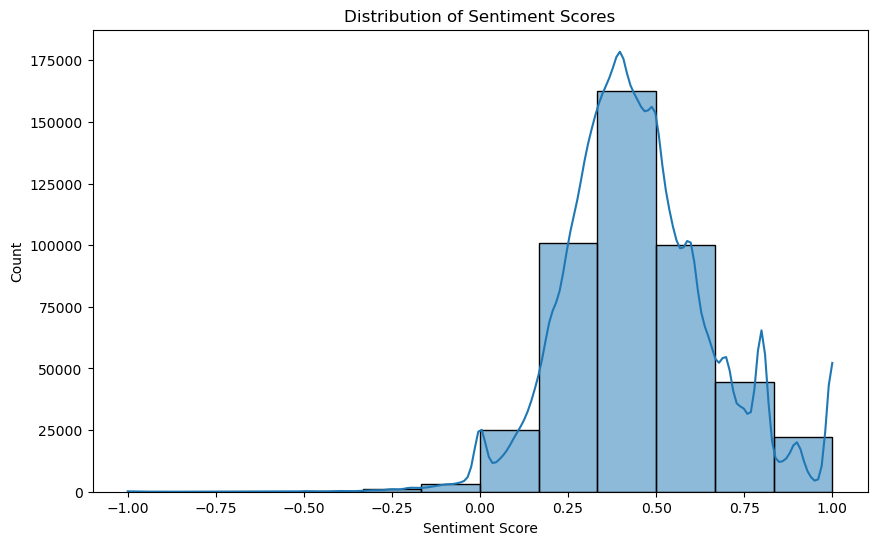

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of sentiment scores
plt.figure(figsize=(10,6))
sns.histplot(reviews['sentiment_blob'], bins=12, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

Now lets look at how sentiments have changed over time

In [16]:
# Average sentiment each year
reviews['date'] = pd.to_datetime(reviews['date']) #conver to datetime
reviews['year'] = reviews['date'].dt.year #extract year from date
yearly_sentiment = reviews.groupby('year')['sentiment_blob'].mean() # Average sentiment per year
print(yearly_sentiment)

year
2009    0.490216
2010    0.422048
2011    0.417263
2012    0.408287
2013    0.412362
2014    0.412792
2015    0.415896
2016    0.427032
2017    0.446839
2018    0.448559
2019    0.460295
2020    0.462533
2021    0.459609
2022    0.453925
2023    0.439499
2024    0.451729
Name: sentiment_blob, dtype: float64


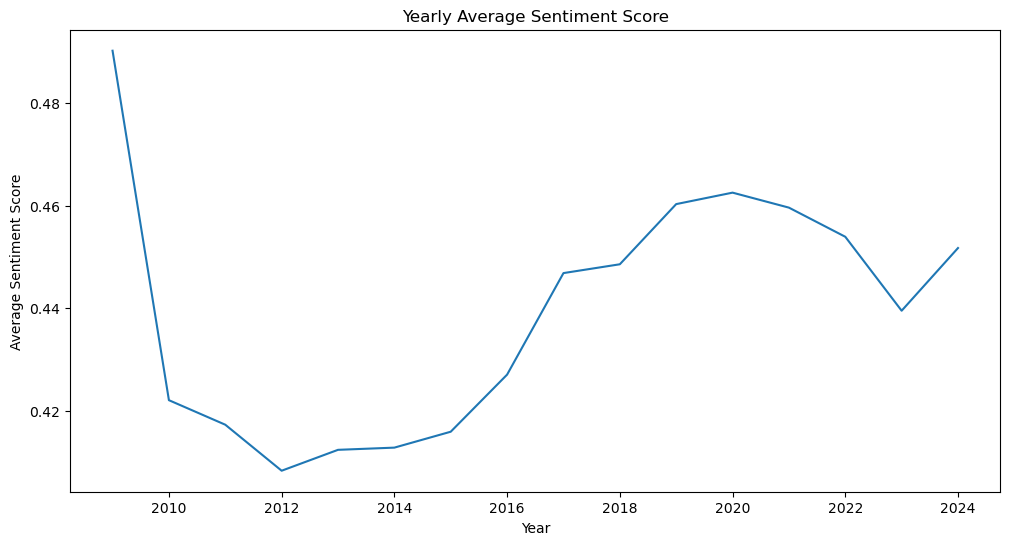

In [17]:
# Plot the average yearly sentiment
plt.figure(figsize=(12,6))
plt.plot(yearly_sentiment)
plt.title('Yearly Average Sentiment Score')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.show()

Lets explore the reviews further - could review length be correlated with sentiment?

In [18]:
# Calculate review length (in words) and as column
reviews['review_length'] = reviews['comments'].apply(lambda x: len(str(x).split()))

In [19]:
# Calculate average review length and sentiment for each year
yearly_data = reviews.groupby('year').agg({
    'review_length': 'mean',
    'sentiment_blob': 'mean'
}).reset_index()
print(yearly_data)
#Calculate correalation for each year
correlations = yearly_data.corr()

# Print out the correlation matrix
print("\n Correlation between review length and sentiment:")
print(correlations)

    year  review_length  sentiment_blob
0   2009      47.285714        0.490216
1   2010      72.507246        0.422048
2   2011      67.113043        0.417263
3   2012      72.007874        0.408287
4   2013      72.729097        0.412362
5   2014      70.721441        0.412792
6   2015      64.511600        0.415896
7   2016      55.336673        0.427032
8   2017      43.489120        0.446839
9   2018      40.646755        0.448559
10  2019      36.609863        0.460295
11  2020      34.063511        0.462533
12  2021      36.378655        0.459609
13  2022      38.176391        0.453925
14  2023      38.569634        0.439499
15  2024      36.667752        0.451729

 Correlation between review length and sentiment:
                    year  review_length  sentiment_blob
year            1.000000      -0.794159        0.362005
review_length  -0.794159       1.000000       -0.827132
sentiment_blob  0.362005      -0.827132        1.000000


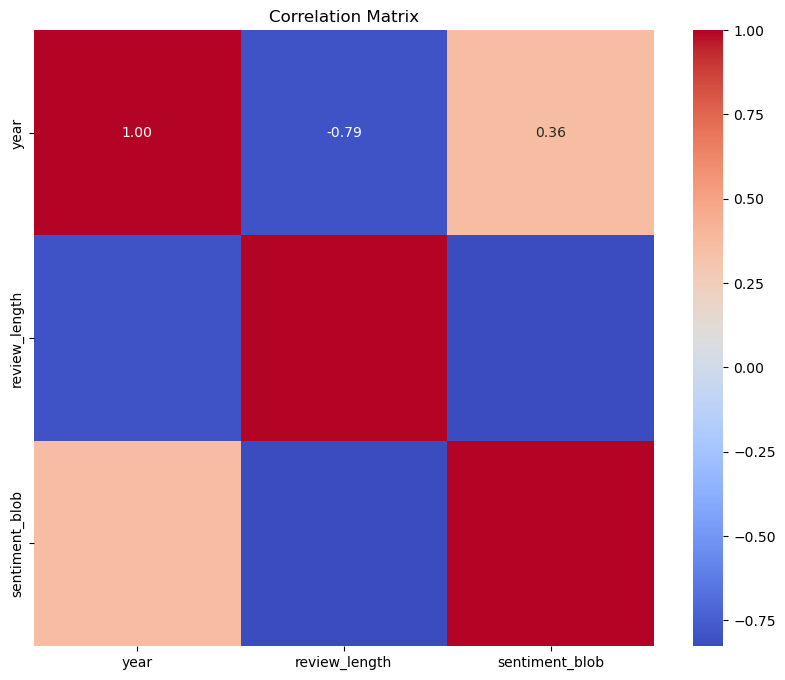

In [23]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


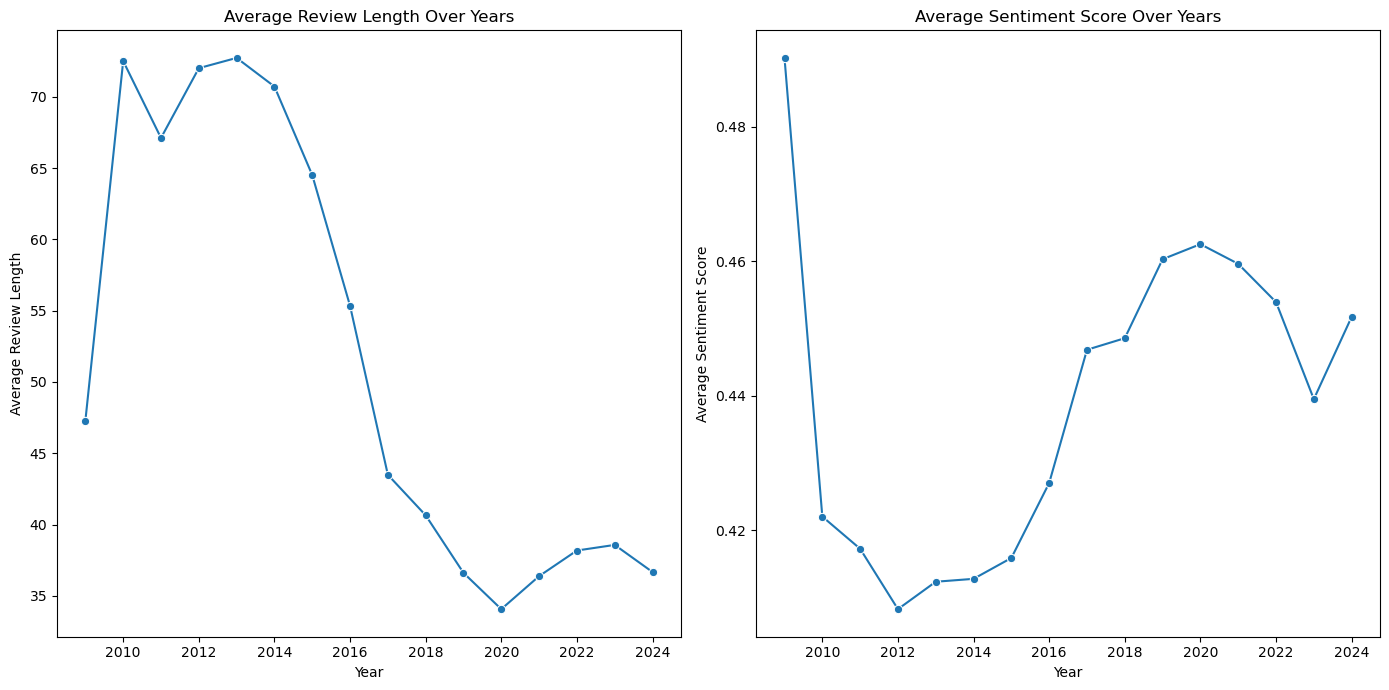

In [20]:
# Plotting
plt.figure(figsize=(14,7))

#plotting review length
plt.subplot(1,2,1)
sns.lineplot(x='year', y='review_length', data=yearly_data, marker ='o')
plt.title('Average Review Length Over Years')
plt.xlabel('Year')
plt.ylabel('Average Review Length')

#plotting sentiment
plt.subplot(1,2,2)
sns.lineplot(x='year', y='sentiment_blob', data=yearly_data, marker='o')
plt.title('Average Sentiment Score Over Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')

plt.tight_layout()
plt.show()

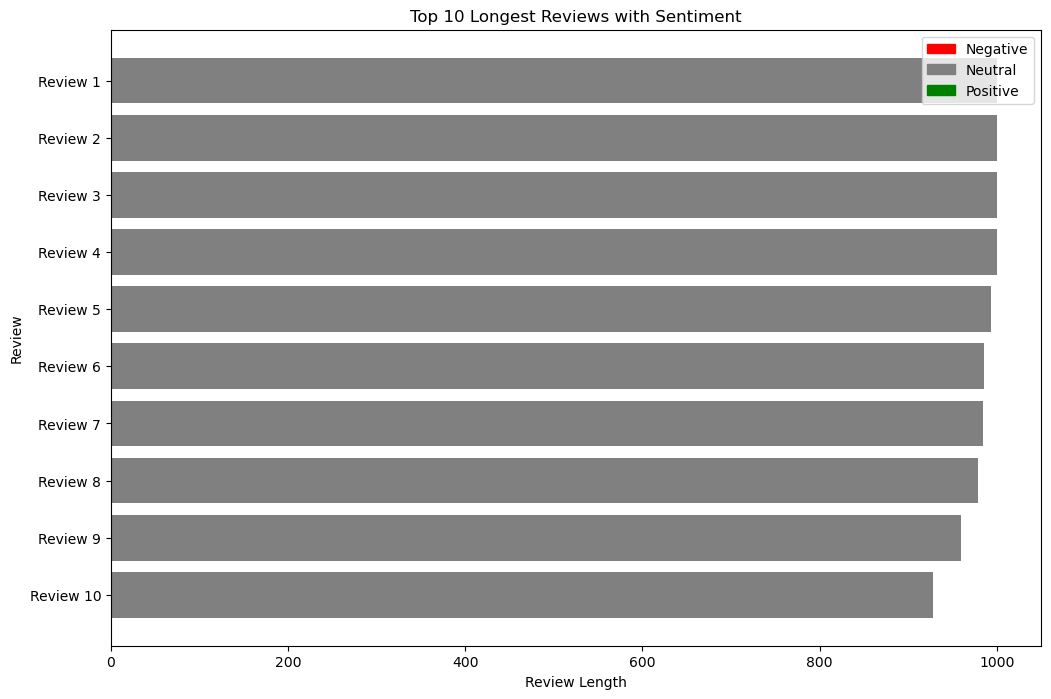

Review 173038:
Length: 1000
Sentiment: 0.01666769195716565
By far the most terrible stay I have ever had anywhere in my life I highly recommend avoiding this place I wanted to cancel at first because she messaged me after I booked to tell me that I cannot lock the door from the outside because the lock had been changed and the key provided does not work on it i don’t know how you change a lock and not provide the new key but instead have the old one didn’t make any sense to me I wanted to cancel but I wasn’t sure how long the refund would take and I needed an Airbnb last minute so she offered me a 10 percent discount it wasn’t about the money I can’t lock the door and leave my belongings inside she said theirs security constantly patrolling the hallways that was a lie their is one security on the main floor that just sits there. My second issue was the toilet it made a very high pitch noise every time you flushed it , and I also noticed a huge stain that they tried removing from the co

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 10 longest reviews
top_10_longest_reviews = reviews.nlargest(10, 'review_length')

# Map sentiment to color
color_map = {1: 'green', 0: 'gray', -1: 'red'}  # Assuming sentiment scores range from -1 to 1

# Create a bar plot
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_10_longest_reviews)), top_10_longest_reviews['review_length'], 
                color=[color_map.get(sentiment, 'gray') for sentiment in top_10_longest_reviews['sentiment_blob']])

plt.xlabel('Review Length')
plt.ylabel('Review')
plt.title('Top 10 Longest Reviews with Sentiment')
plt.yticks(range(len(top_10_longest_reviews)), ['Review ' + str(i+1) for i in range(len(top_10_longest_reviews))])

# Add legend
legend_labels = ['Negative', 'Neutral', 'Positive']
legend_colors = ['red', 'gray', 'green']
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in legend_colors]
plt.legend(legend_handles, legend_labels)

plt.gca().invert_yaxis()  # Invert y-axis to display the longest review at the top

plt.show()

# Print the top 10 longest reviews along with their sentiments
for index, review in top_10_longest_reviews.iterrows():
    print(f"Review {index}:")
    print(f"Length: {review['review_length']}")
    print("Sentiment:", review['sentiment_blob'])
    print(review['comments'])
    print("\n")


The sentiment analysis of all the reviews seems to be neutral, which manually reading them you can see that they appear to be quite negative - so now i will use a different sentiment analysis tool and see if it works differently

In [27]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_vader_sentiment(text):
    # Get the polarity scores
    scores = sid.polarity_scores(text)
    # Return the compound score, which is a normalized score between -1 and 1
    return scores['compound']

# Apply the function to each comment in your DataFrame
reviews['vader_sentiment'] = reviews['cleaned_comments'].apply(get_vader_sentiment)

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\areem\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


VADER Sentiment Summary Statistics:
 count    459355.000000
mean          0.827028
std           0.235763
min          -0.998500
25%           0.795500
50%           0.908900
75%           0.958100
max           0.999600
Name: vader_sentiment, dtype: float64


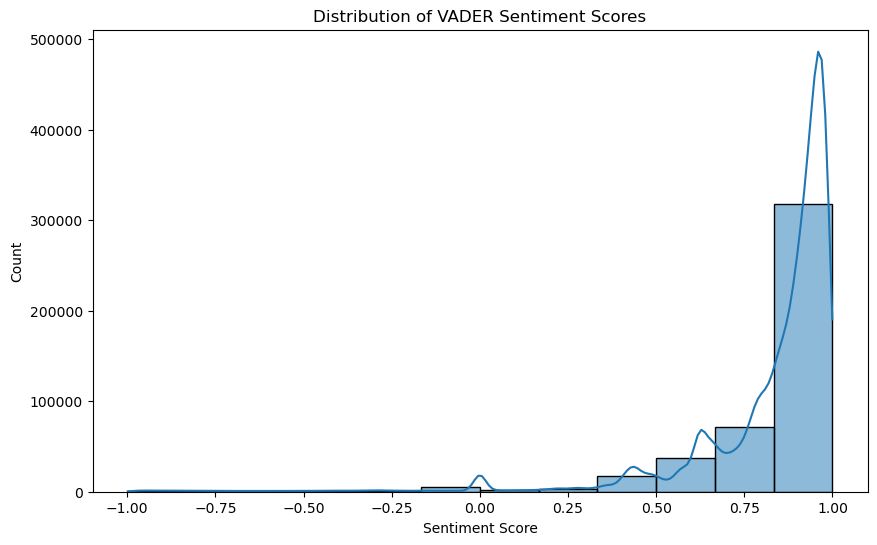

In [28]:
# Get summary statistics for VADER sentiment
vader_sentiment_stats = reviews['vader_sentiment'].describe()
print('VADER Sentiment Summary Statistics:\n', vader_sentiment_stats)

# Plot the distribution of VADER sentiment scores
plt.figure(figsize=(10,6))
sns.histplot(reviews['vader_sentiment'], bins=12, kde=True)
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

Now, lets compare the sentiments of those top 10 longest reviews when using VADER vs TextBlob

In [30]:
# Print sentiment scores for the top 10 longest reviews
for i, review in top_10_longest_reviews.iterrows():
    print(f"Review {i}:")
    print(f"Text: {review['comments'][:300]}...")  # Print only the first 300 characters for brevity
    print(f"Length: {review['review_length']}")
    print(f"Sentiment (TextBlob): {review['sentiment_blob']}")
    print(f"Sentiment (VADER): {review['vader_sentiment']}")
    print()

Review 173038:
Text: By far the most terrible stay I have ever had anywhere in my life I highly recommend avoiding this place I wanted to cancel at first because she messaged me after I booked to tell me that I cannot lock the door from the outside because the lock had been changed and the key provided does not work on ...
Length: 1000
Sentiment (TextBlob): 0.01666769195716565
Sentiment (VADER): -0.9323

Review 271040:
Text: First of all: the location of the apartment is absolutely magnificent and the view to the CN Tower is really spectacular. We couldn't get enough of the view within the 5 days. The communication with Ramy was also very easy and uncomplicated. He always responded very quickly, which was really great. ...
Length: 1000
Sentiment (TextBlob): 0.08722425722425724
Sentiment (VADER): -0.9985

Review 283876:
Text: If I were to summarize our experience staying at Adrienne + Brandon’s home in Toronto in one line; is simply the feeling of staying over at your best friend’s home

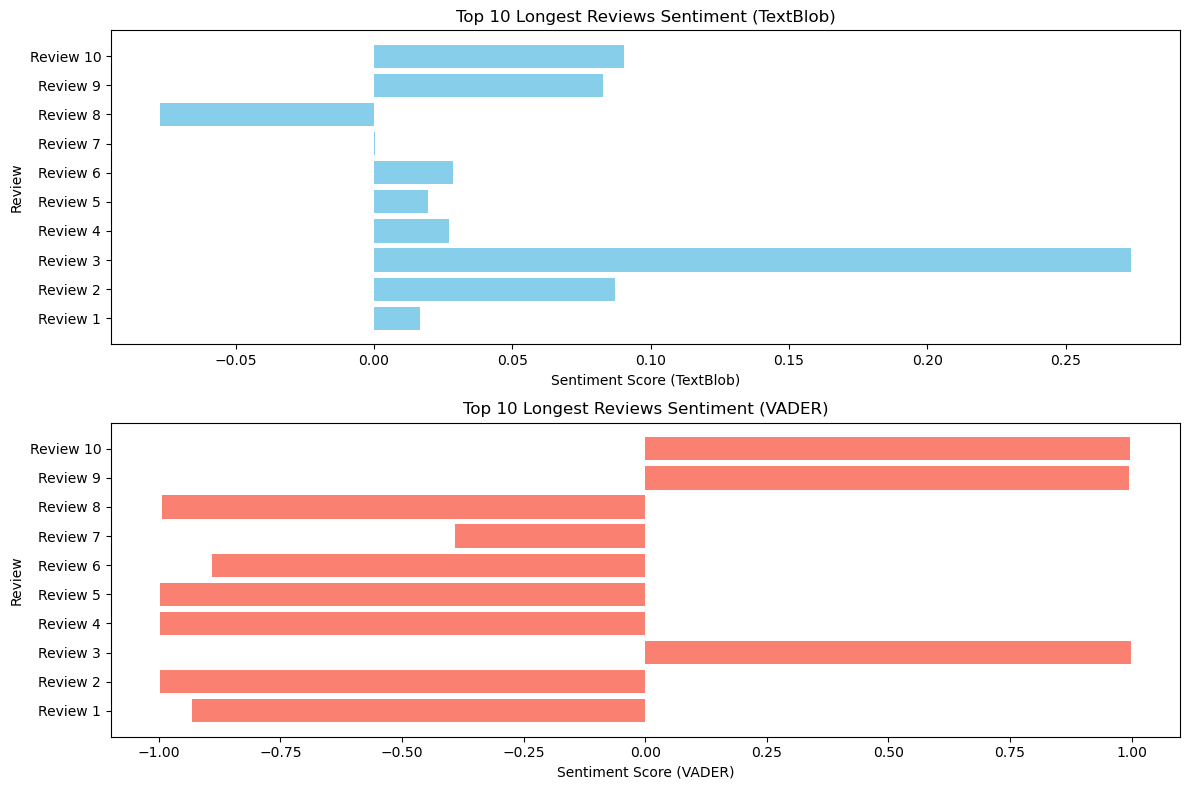

In [29]:
# Select the top 10 longest reviews
top_10_longest_reviews = reviews.nlargest(10, 'review_length')

# Plot the sentiment scores for the top 10 longest reviews
plt.figure(figsize=(12, 8))

# Plot sentiment scores from TextBlob
plt.subplot(2, 1, 1)
plt.barh(range(len(top_10_longest_reviews)), top_10_longest_reviews['sentiment_blob'], color='skyblue')
plt.xlabel('Sentiment Score (TextBlob)')
plt.ylabel('Review')
plt.title('Top 10 Longest Reviews Sentiment (TextBlob)')
plt.yticks(range(len(top_10_longest_reviews)), ['Review ' + str(i+1) for i in range(len(top_10_longest_reviews))])

# Plot sentiment scores from VADER
plt.subplot(2, 1, 2)
plt.barh(range(len(top_10_longest_reviews)), top_10_longest_reviews['vader_sentiment'], color='salmon')
plt.xlabel('Sentiment Score (VADER)')
plt.ylabel('Review')
plt.title('Top 10 Longest Reviews Sentiment (VADER)')
plt.yticks(range(len(top_10_longest_reviews)), ['Review ' + str(i+1) for i in range(len(top_10_longest_reviews))])

plt.tight_layout()
plt.show()


In [34]:
# Top 5 reviews with lowest TextBlob sentiment scores
top_5_textblob_lowest = reviews.nsmallest(5, 'sentiment_blob')
print("Top 5 Reviews with Lowest TextBlob Sentiment Scores:")
for index, row in top_5_textblob_lowest.iterrows():
    print("Review:", row['comments'])
    print("Length:", len(row['comments']))
    print("Sentiment (TextBlob):", row['sentiment_blob'])
    print()

# Top 5 reviews with lowest VADER sentiment scores
top_5_vader_lowest = reviews.nsmallest(5, 'vader_sentiment')
print("Top 5 Reviews with Lowest VADER Sentiment Scores:")
for index, row in top_5_vader_lowest.iterrows():
    print("Review:", row['comments'])
    print("Length:", len(row['comments']))
    print("Sentiment (VADER):", row['vader_sentiment'])
    print()

Top 5 Reviews with Lowest TextBlob Sentiment Scores:
Review: My check-in went very bad, the host did not reply to the messages and delayed the check-in time to 7:15 pm!! 
Length: 109
Sentiment (TextBlob): -1.0

Review: The service at airbnb was terrible. The accommodation is not recommended.
Length: 73
Sentiment (TextBlob): -1.0

Review: Privacy was terrible. I can seen everything  through the front door while looking into and out of the basement apartment
Length: 120
Sentiment (TextBlob): -1.0

Review: Horrible
Length: 8
Sentiment (TextBlob): -1.0

Review: Horrible wifi connection, no tv Chanel’s. If you need a bed for just the night it will do, but wouldn’t stay longer.
Length: 116
Sentiment (TextBlob): -1.0

Top 5 Reviews with Lowest VADER Sentiment Scores:
Review: First of all: the location of the apartment is absolutely magnificent and the view to the CN Tower is really spectacular. We couldn't get enough of the view within the 5 days. The communication with Ramy was also very eas

In [35]:
# Top 5 reviews with highest TextBlob sentiment scores
top_5_textblob_highest = reviews.nlargest(5, 'sentiment_blob')
print("Top 5 Reviews with Highest TextBlob Sentiment Scores:")
for index, row in top_5_textblob_highest.iterrows():
    print("Review:", row['comments'])
    print("Length:", len(row['comments']))
    print("Sentiment (TextBlob):", row['sentiment_blob'])
    print()

# Top 5 reviews with highest VADER sentiment scores
top_5_vader_highest = reviews.nlargest(5, 'vader_sentiment')
print("Top 5 Reviews with Highest VADER Sentiment Scores:")
for index, row in top_5_vader_highest.iterrows():
    print("Review:", row['comments'])
    print("Length:", len(row['comments']))
    print("Sentiment (VADER):", row['vader_sentiment'])
    print()

Top 5 Reviews with Highest TextBlob Sentiment Scores:
Review: Just the basics, perfect for what i was looking for in Toronto. Convenient location.
Length: 84
Sentiment (TextBlob): 1.0

Review: perfect location. perfect space
Length: 31
Sentiment (TextBlob): 1.0

Review: Perfect location, subway just in front of the building. Longos in 1 min walk.
Length: 77
Sentiment (TextBlob): 1.0

Review: Great place!
Length: 12
Sentiment (TextBlob): 1.0

Review: Wonderful location and room with amazing hosts! Thank you!!
Length: 59
Sentiment (TextBlob): 1.0

Top 5 Reviews with Highest VADER Sentiment Scores:
Review: Patrick's home was absolutely amazing!  We were so grateful every day of our family vacation that we chose his home to stay in.  It is roomy and beautiful and had everything we could possibly need. Comfortable beds with nice sheets. Lots of towels and a fully stocked kitchen.  Hundreds of books to look through, and interesting art to admire made downtime fun. It was great to have lots o

Lets extract the top terms in positive and negative reviews now

In [37]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,language,sentiment_blob,year,review_length,vader_sentiment
0,1419,38924112,2015-07-19,11308465,Marcela,Having the opportunity of arriving to Alexandr...,Having the opportunity of arriving to Alexandr...,en,0.410104,2015,87,0.9940
1,1419,44791978,2015-08-29,9580285,Marco,We have no enough words to describe how beauty...,We have no enough words to describe how beauty...,en,0.266667,2015,45,0.6580
2,1419,45957133,2015-09-07,38394721,Andrea,The listing was exceptional and an even better...,The listing was exceptional and an even better...,en,0.576111,2015,94,0.9895
3,1419,67295154,2016-03-28,3515044,Shaun,Alexandra's home was amazing and in such a nea...,Alexandra's home was amazing and in such a nea...,en,0.295000,2016,64,0.9741
4,1419,177702208,2017-08-03,13987100,Kate,Beautiful home. Very comfortable and clean. Pe...,Beautiful home. Very comfortable and clean. Pe...,en,0.502963,2017,44,0.9793


Next let's extract the top terms in positive and negative reviews. We'll need to further preprocess the text for that

In [43]:
def classify_sentiment(sentiment, threshold=0.5):
  if sentiment > threshold:
    return 'positive'
  elif sentiment < -threshold:
    return 'negative'
  else:
    return 'neutral'

reviews['textblob_class'] = reviews['sentiment_blob'].apply(classify_sentiment)
reviews['vader_class'] = reviews['vader_sentiment'].apply(classify_sentiment)

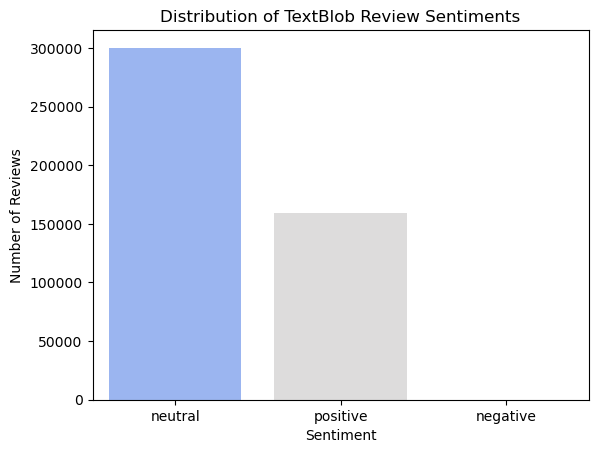

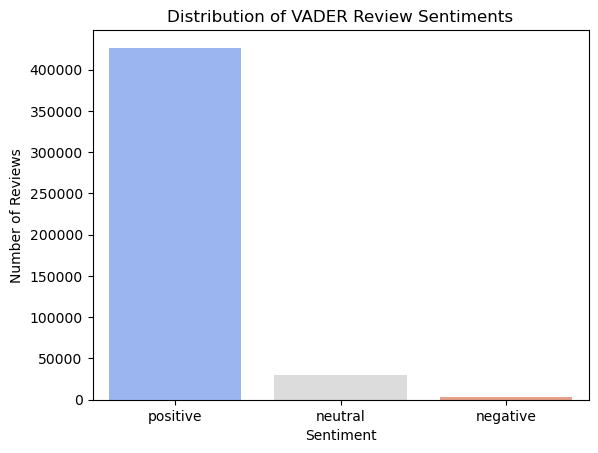

In [46]:
# Plotting the distribution of sentiments
sns.countplot(x='textblob_class', data=reviews, palette='coolwarm')
plt.title('Distribution of TextBlob Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

sns.countplot(x='vader_class', data=reviews, palette='coolwarm')
plt.title('Distribution of VADER Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(text_series, n=20):
    cv = CountVectorizer(stop_words='english')  # Initialize the CountVectorizer
    X = cv.fit_transform(text_series)  # Fit and transform the text data to a word frequency array
    sum_words = X.sum(axis=0)  # Sum word occurrences
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]  # Pair words with their frequencies
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)  # Sort words by frequency
    return words_freq[:n]  # Return top n words

# Function to plot top words
def plot_top_words(top_words, title):
    words = [word[0] for word in top_words]
    counts = [word[1] for word in top_words]
    sns.barplot(x=counts, y=words, palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

Top positive words from TextBlob: [('great', 123409), ('place', 78308), ('stay', 64701), ('location', 61990), ('host', 43027), ('clean', 36594), ('nice', 29583), ('perfect', 26115), ('good', 22272), ('toronto', 20106), ('recommend', 19537), ('amazing', 19187), ('beautiful', 17200), ('apartment', 16606), ('easy', 14960), ('comfortable', 14951), ('wonderful', 14465), ('close', 13301), ('excellent', 13148), ('really', 12488)]
Top negative words from TextBlob: [('place', 53), ('bad', 49), ('dirty', 35), ('terrible', 30), ('worst', 26), ('stay', 26), ('host', 24), ('disappointed', 23), ('room', 22), ('experience', 20), ('bed', 19), ('airbnb', 16), ('kitchen', 13), ('recommend', 13), ('like', 13), ('cold', 13), ('apartment', 12), ('disgusting', 11), ('people', 10), ('communication', 10)]


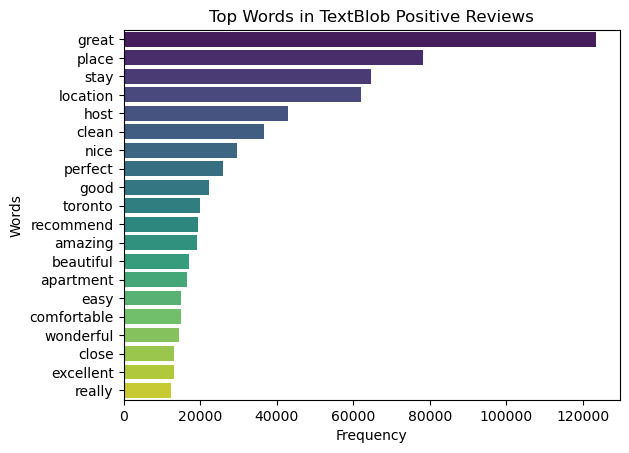

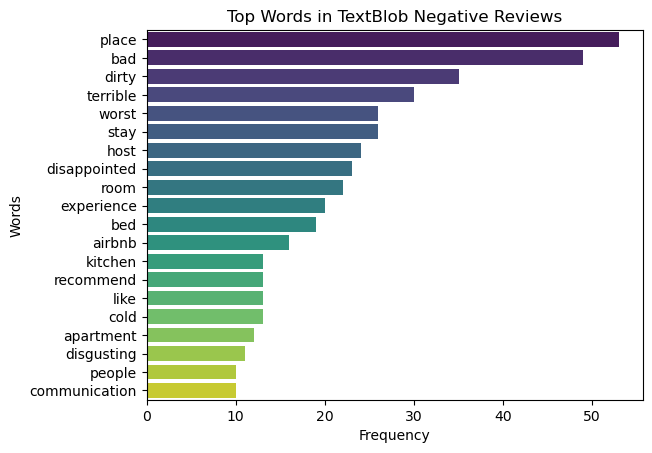

In [51]:
positive_reviews_textblob = reviews[reviews['textblob_class'] == 'positive']['cleaned_comments']
negative_reviews_textblob = reviews[reviews['textblob_class'] == 'negative']['cleaned_comments']

top_positive_words_textblob = get_top_words(positive_reviews_textblob)
top_negative_words_textblob = get_top_words(negative_reviews_textblob)

# Display the top words for each sentiment
print("Top positive words from TextBlob:", top_positive_words_textblob)
print("Top negative words from TextBlob:", top_negative_words_textblob)

# Plot top words for English positive reviews
plot_top_words(top_positive_words_textblob, 'Top Words in TextBlob Positive Reviews')

# Plot top words for English negative reviews
plot_top_words(top_negative_words_textblob, 'Top Words in TextBlob Negative Reviews')

Top positive words from VADER: [('great', 273460), ('place', 256857), ('stay', 223804), ('location', 154359), ('clean', 148611), ('host', 121071), ('toronto', 90042), ('nice', 87107), ('recommend', 86109), ('comfortable', 71752), ('apartment', 70802), ('definitely', 65990), ('easy', 63604), ('perfect', 59704), ('really', 57334), ('good', 56161), ('close', 55190), ('amazing', 54943), ('home', 53122), ('space', 47150)]
Top negative words from VADER: [('place', 2241), ('host', 1751), ('stay', 1436), ('room', 1161), ('airbnb', 949), ('dirty', 876), ('bed', 826), ('did', 820), ('apartment', 818), ('clean', 797), ('time', 782), ('house', 771), ('night', 764), ('location', 744), ('door', 671), ('just', 667), ('bathroom', 661), ('like', 639), ('kitchen', 635), ('day', 620)]


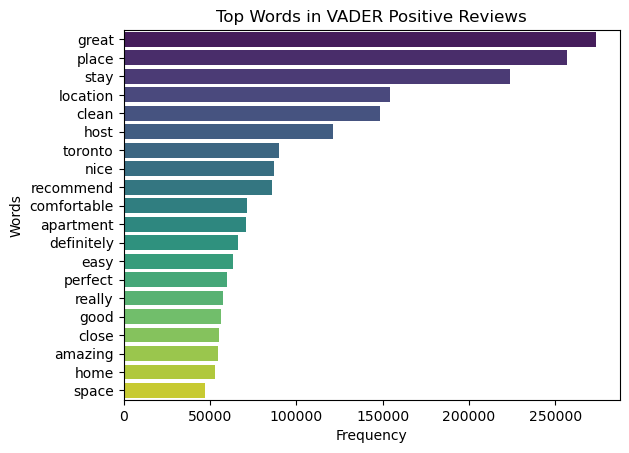

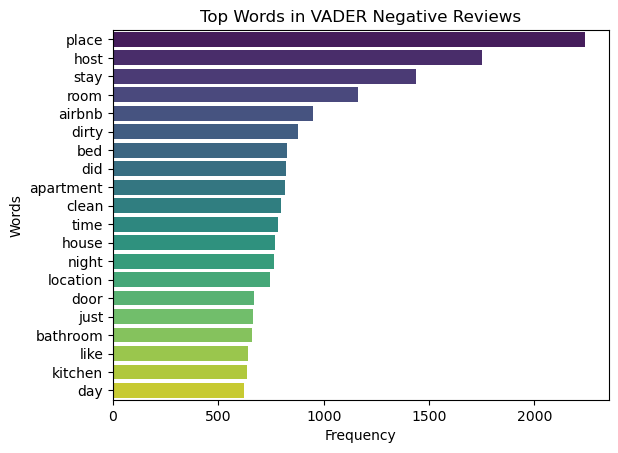

In [52]:
positive_reviews_vader = reviews[reviews['vader_class'] == 'positive']['cleaned_comments']
negative_reviews_vader = reviews[reviews['vader_class'] == 'negative']['cleaned_comments']

top_positive_words_vader = get_top_words(positive_reviews_vader)
top_negative_words_vader = get_top_words(negative_reviews_vader)

# Display the top words for each sentiment
print("Top positive words from VADER:", top_positive_words_vader)
print("Top negative words from VADER:", top_negative_words_vader)

# Plot top words for English positive reviews
plot_top_words(top_positive_words_vader, 'Top Words in VADER Positive Reviews')

# Plot top words for English negative reviews
plot_top_words(top_negative_words_vader, 'Top Words in VADER Negative Reviews')

Some words are still appearing, that may not necessairly be stop words, but they don't contribute. We'll remove those now as well and see what the results are like after. I will use the same code, but add the additional stop words

In [74]:
# ADD ADDITIONAL STOP WORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# Define additional stopwords
additional_stop_words = ['just', 'really', 'like', 'day', 'place', 'stay', 'did', 'best', 'thank',
                        'nice', 'good', 'dont', 'didnt', 'home', 'recommend', 'great', 'worst', 'awesome',
                        'highly', 'perfect', 'apartment', 'disappointed', 'excellent', 'amazing', 'super', 
                        'wonderful']

# Combine with the default English stop words list from CountVectorizer
custom_stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

# Convert custom_stop_words from frozenset to list
custom_stop_words_list = list(custom_stop_words)

def get_top_words_custom_stopwords(text_series, n=20):
    cv = CountVectorizer(stop_words=custom_stop_words_list)  # Initialize the CountVectorizer
    X = cv.fit_transform(text_series)  # Fit and transform the text data to a word frequency array
    sum_words = X.sum(axis=0)  # Sum word occurrences
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]  # Pair words with their frequencies
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)  # Sort words by frequency
    return words_freq[:n]  # Return top n words

Top positive words from TextBlob: [('location', 61990), ('host', 43027), ('clean', 36594), ('toronto', 20106), ('beautiful', 17200), ('easy', 14960), ('comfortable', 14951), ('wonderful', 14465), ('close', 13301), ('view', 12373), ('space', 11574), ('hosts', 9679), ('communication', 9595), ('house', 9364), ('downtown', 8957), ('helpful', 8909), ('time', 8664), ('room', 8188), ('awesome', 8054), ('friendly', 7962)]
Top negative words from TextBlob: [('bad', 49), ('dirty', 35), ('terrible', 30), ('host', 24), ('room', 22), ('experience', 20), ('bed', 19), ('airbnb', 16), ('kitchen', 13), ('cold', 13), ('disgusting', 11), ('people', 10), ('communication', 10), ('night', 10), ('sleep', 10), ('floor', 9), ('small', 9), ('bathroom', 9), ('check', 9), ('smell', 8)]


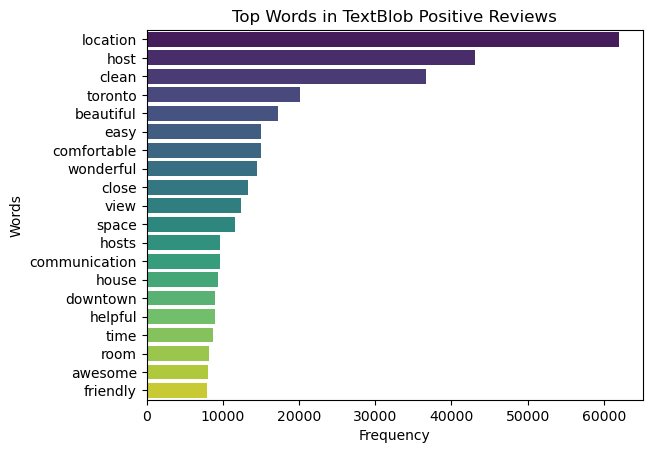

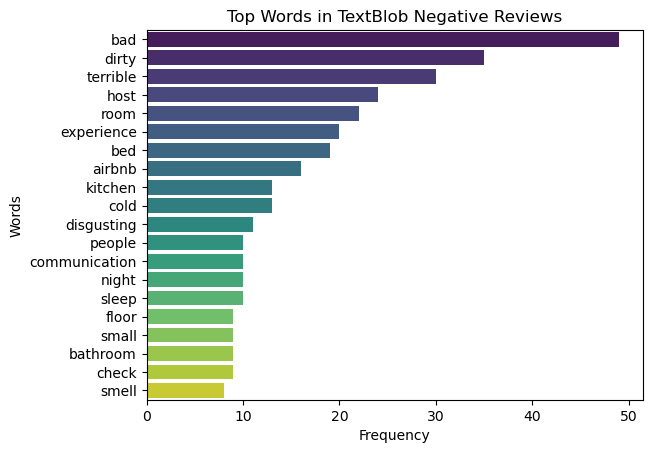

In [75]:
top_positive_words_textblob = get_top_words_custom_stopwords(positive_reviews_textblob)
top_negative_words_textblob = get_top_words_custom_stopwords(negative_reviews_textblob)

# Display the top words for each sentiment
print("Top positive words from TextBlob:", top_positive_words_textblob)
print("Top negative words from TextBlob:", top_negative_words_textblob)

# Plot top words for English positive reviews
plot_top_words(top_positive_words_textblob, 'Top Words in TextBlob Positive Reviews')

# Plot top words for English negative reviews
plot_top_words(top_negative_words_textblob, 'Top Words in TextBlob Negative Reviews')

Top positive words from VADER: [('location', 154359), ('clean', 148611), ('host', 121071), ('toronto', 90042), ('comfortable', 71752), ('definitely', 65990), ('easy', 63604), ('close', 55190), ('space', 47150), ('room', 45509), ('time', 44945), ('house', 44581), ('helpful', 41326), ('beautiful', 40300), ('downtown', 39551), ('responsive', 37621), ('restaurants', 37479), ('quiet', 36170), ('friendly', 35561), ('needed', 34087)]
Top negative words from VADER: [('host', 1751), ('room', 1161), ('airbnb', 949), ('dirty', 876), ('bed', 826), ('clean', 797), ('time', 782), ('house', 771), ('night', 764), ('location', 744), ('door', 671), ('bathroom', 661), ('kitchen', 635), ('unit', 577), ('check', 536), ('experience', 525), ('broken', 490), ('floor', 475), ('building', 471), ('people', 462)]


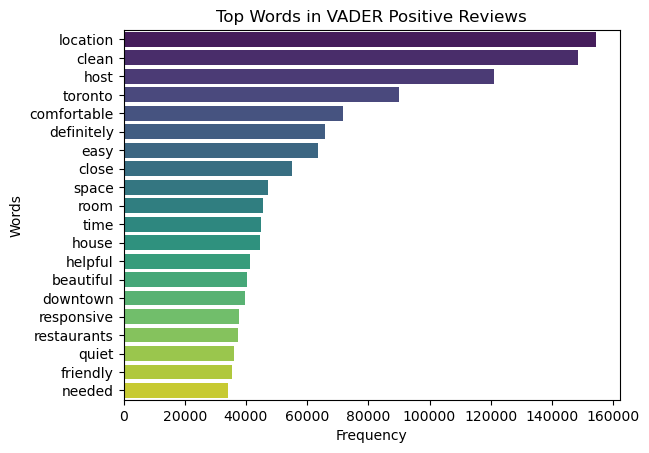

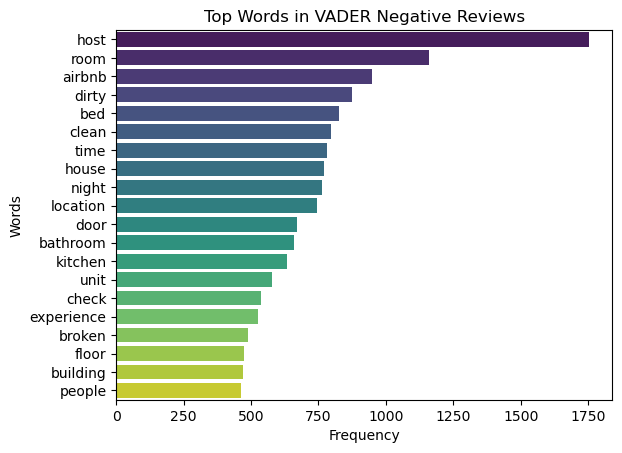

In [76]:
top_positive_words_vader = get_top_words_custom_stopwords(positive_reviews_vader)
top_negative_words_vader = get_top_words_custom_stopwords(negative_reviews_vader)

# Display the top words for each sentiment
print("Top positive words from VADER:", top_positive_words_vader)
print("Top negative words from VADER:", top_negative_words_vader)

# Plot top words for English positive reviews
plot_top_words(top_positive_words_vader, 'Top Words in VADER Positive Reviews')

# Plot top words for English negative reviews
plot_top_words(top_negative_words_vader, 'Top Words in VADER Negative Reviews')

While many words are useful, even after adding additonal stop words, there are many words which do not provide any menaing inisght
In the context of extracting meaningful insights from guest reviews, it's helpful to distinguish between adjectives that provide specific, actionable feedback and those that are more general expressions of sentiment.

Actionable Adjectives:

Clean/Dirty: Directly relates to the hygiene and upkeep of the property.
Responsive/Unresponsive: Indicates the host's effectiveness in communication.
Helpful/Unhelpful: Reflects on the support and service provided by the host.
These adjectives give clear indicators of areas that can be improved or strengths that can be maintained. They are directly related to the guest's experience in a way that can guide improvements or highlight positive aspects of the service.

General Sentiment Adjectives:

Amazing/Awesome/Super/Wonderful: While these adjectives express a high level of satisfaction, they are less specific about what exactly made the experience positive. They are useful for gauging overall sentiment but less so for identifying specific areas of strength or 

As such, we can use POT (Part-of-Speech) tagging to help with thisweakness.

In [77]:
import nltk
nltk.download('punkt')  # Tokenizer
nltk.download('averaged_perceptron_tagger')  # POS tagger

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\areem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\areem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [79]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,language,sentiment_blob,year,review_length,vader_sentiment,textblob_class,vader_class,adjectives
0,1419,38924112,2015-07-19,11308465,Marcela,Having the opportunity of arriving to Alexandr...,Having the opportunity of arriving to Alexandr...,en,0.410104,2015,87,0.9940,neutral,positive,"[super, mega, easy, super, calm, pretty, beaut..."
1,1419,44791978,2015-08-29,9580285,Marco,We have no enough words to describe how beauty...,We have no enough words to describe how beauty...,en,0.266667,2015,45,0.6580,neutral,positive,"[enough, beautyful, tasteful, functional, toys..."
2,1419,45957133,2015-09-07,38394721,Andrea,The listing was exceptional and an even better...,The listing was exceptional and an even better...,en,0.576111,2015,94,0.9895,positive,positive,"[exceptional, better, beautiful, available, wo..."
3,1419,67295154,2016-03-28,3515044,Shaun,Alexandra's home was amazing and in such a nea...,Alexandra's home was amazing and in such a nea...,en,0.295000,2016,64,0.9741,neutral,positive,"[amazing, such, neat, described, great, great,..."
4,1419,177702208,2017-08-03,13987100,Kate,Beautiful home. Very comfortable and clean. Pe...,Beautiful home. Very comfortable and clean. Pe...,en,0.502963,2017,44,0.9793,positive,positive,"[comfortable, clean, amazing, complete, useful..."


In [82]:
reviews.to_csv('reviews_sentiment.csv', index=False, quoting=1, encoding='utf-8')

Are these extracted features alone enough to use to predict the rating? Lets test with a model

Let's implement emotional recognition now - not just 'positive/negative' - joy, anger, etc

In [15]:
!pip install NRCLex
from nrclex import NRCLex

# Function to extract emotions from text
def extract_emotions(text):
    emotion = NRCLex(text)
    return emotion.affect_frequencies  # This returns a dictionary of emotion scores

reviews['emotions'] = reviews['cleaned_comments'].apply(extract_emotions)

Defaulting to user installation because normal site-packages is not writeable


In [16]:
reviews['emotions'].head()

0    {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...
1    {'fear': 0.07692307692307693, 'anger': 0.15384...
2    {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...
3    {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...
4    {'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't...
Name: emotions, dtype: object

In [19]:
# Initialize a dictionary to hold aggregated emotion scores
aggregate_emotions = defaultdict(float)

# Sum up all the emotion scores from each review
for emotion_scores in reviews['emotions']:
    for emotion, score in emotion_scores.items():
        aggregate_emotions[emotion] += score

# Convert the aggregated scores to a DataFrame for easier analysis and visualization
emotion_df = pd.DataFrame(list(aggregate_emotions.items()), columns=['Emotion', 'TotalScore'])

# Sort the DataFrame by TotalScore to see which emotions are most prevalent
emotion_df = emotion_df.sort_values(by='TotalScore', ascending=False)

# Display the DataFrame
print(emotion_df)

         Emotion     TotalScore
5       positive  140417.525319
3          trust   89466.864002
9            joy   65087.062051
10  anticipation   50705.630371
4       surprise   17509.674546
6       negative   12061.208819
7        sadness   11141.475630
0           fear    3576.017096
1          anger    3157.540067
8        disgust    1836.002099
2        anticip       0.000000


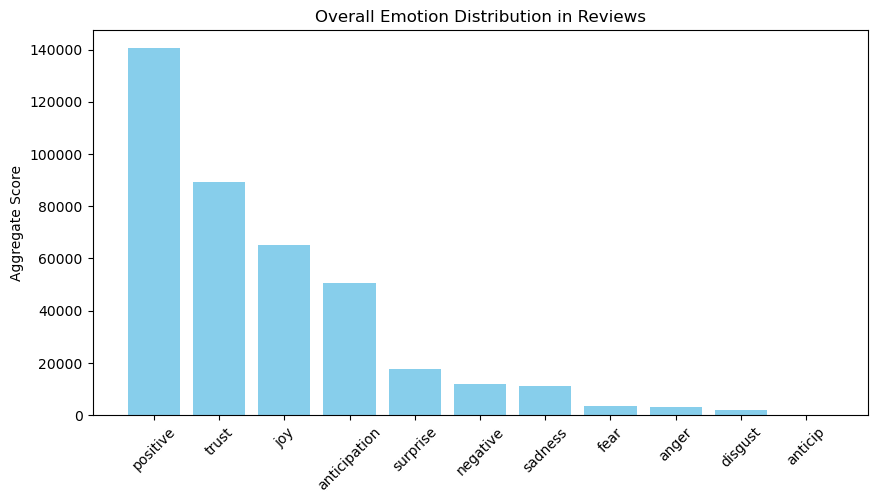

In [20]:
# Plot emotion distribution
plt.figure(figsize=[10,5])
plt.bar(emotion_df['Emotion'], emotion_df['TotalScore'], color='skyblue')
plt.title('Overall Emotion Distribution in Reviews')
plt.ylabel('Aggregate Score')
plt.xticks(rotation=45)
plt.show()

Lets compare the results from TextBlob sentiment analysis with NRCLex Emotion Analysis

In [23]:
from scipy.stats import pearsonr

# Ensure 'emotion_scores' are dictionaries; if they're strings, convert them
reviews['emotions'] = reviews['emotions'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Extract 'positive' and 'negative' emotion scores directly within the correlation calculation
positive_emotion_scores = reviews['emotions'].apply(lambda x: x.get('positive', 0))
negative_emotion_scores = reviews['emotions'].apply(lambda x: x.get('negative'), 0)

# Calculate the Pearson correlation coefficient
corr_positive, _ = pearsonr(positive_emotion_scores, reviews['sentiment_blob'])
corr_negative, _ = pearsonr(negative_emotion_scores, reviews['sentiment_blob'])

print(f'Pearson correlation between positive emotion and sentiment polarity: {corr_positive}')
print(f'Pearson correlation between negative emotion and sentiment polarity: {corr_negative}')

Pearson correlation between positive emotion and sentiment polarity: -0.1446739155605164
Pearson correlation between negative emotion and sentiment polarity: -0.2647066773020886


Now lets do topic modeling

In [ ]:
# TOPIC MODELING

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert reviews to a document-term matrix
count_vect = CountVectorizer(max_features=5000, stop_words='english')
doc_term_matrix = count_vect.fit_transform(reviews['cleaned_comments'])

# LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # n_components is the number of topics
lda_dtm = lda.fit_transform(doc_term_matrix)

# Assign the dominant topic to each review based on highest contribution
reviews['dominant_topic'] = lda_dtm.argmax(axis=1)

# Show top words for each topic
def show_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# Call this function to display top words
show_top_words(lda, count_vect.get_feature_names_out(), 10)

The results of the LDA topic modeling are not very useful - lets try something else

In [25]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459355 entries, 0 to 459354
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   listing_id        459355 non-null  int64         
 1   id                459355 non-null  int64         
 2   date              459355 non-null  datetime64[ns]
 3   reviewer_id       459355 non-null  int64         
 4   reviewer_name     459355 non-null  object        
 5   comments          459355 non-null  object        
 6   cleaned_comments  459355 non-null  object        
 7   language          459355 non-null  object        
 8   sentiment_blob    459355 non-null  float64       
 9   year              459355 non-null  int32         
 10  review_length     459355 non-null  int64         
 11  emotions          459355 non-null  object        
 12  dominant_topic    459355 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5), objec

Before being able to use the comments in a predictive model, we will need to preprocess them and convert them into a format that the model can use. We will use a TF-IDF to convert the text comments into numerical features.

I preprocess the review text by removing stopwords, punctuation and lemmatizing the words.

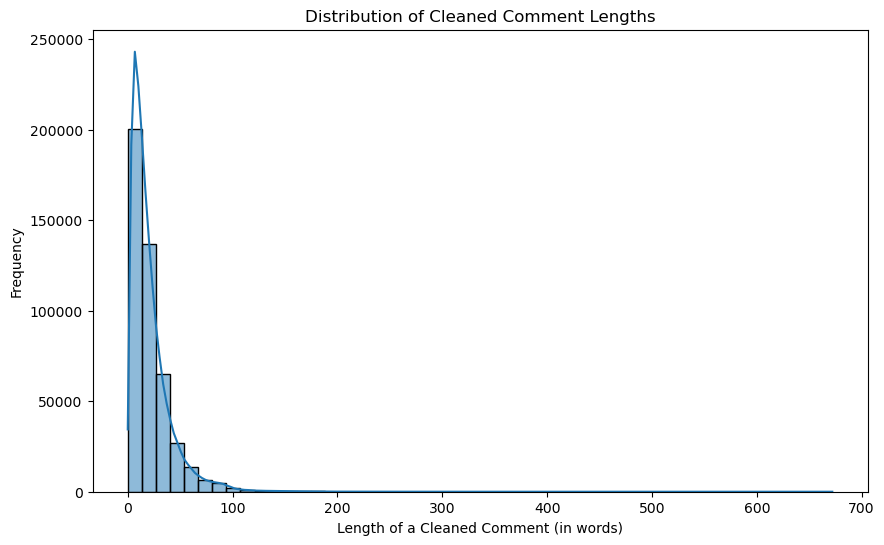

In [90]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK's default English stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z]', ' ', text)
    # Remove stopwords and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing
reviews['cleaned_comments'] = reviews['comments'].apply(lambda x: preprocess_text(str(x)))

# Now lets visualize the comment length after preprocessing
reviews['cleaned_comment_length'] = reviews['cleaned_comments'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(reviews['cleaned_comment_length'], bins=50, kde=True)
plt.title('Distribution of Cleaned Comment Lengths')
plt.xlabel('Length of a Cleaned Comment (in words)')
plt.ylabel('Frequency')
plt.show()

Now, I will convert the preprocessed text into a more usable form for machine learning through the TF-IDF vectorization.
The TfidfVectorizer converts the collection of raw documents into a matrix of TF-IDF features. I have limited to 1000 features for the initial analysis/efficiency. The shape of the matrix gives us the number of reviews and the number of distinct words accross all reviews.

In [92]:
# Use TfidfVectorizer to convert the text data to numerical form
tfidf = TfidfVectorizer(max_features=1000)

# Fit and transform the cleaned comments
tfidf_matrix = tfidf.fit_transform(reviews['cleaned_comments'])

# Summarize the TF-IDF matrix
print(tfidf_matrix.shape)

(459355, 1000)


Lets now try to visualize the information contained in the TF-IDF matrix. While visualizing the enitre TF-IDF matrix can be challenging due to its high dimensionality and sparsity, we can extract from it.
First, I will extract the top TF_IDF terms for the entire corpus. I will visualize the terms in the corpus with the highest average TF-IDF scores. These terms are often the most relevant across all documents(comments)
The barchart shows the terms with the highest summed TF-IDF scores across all documents. High-scoring terms are typically more important in the context of the entire corpus.

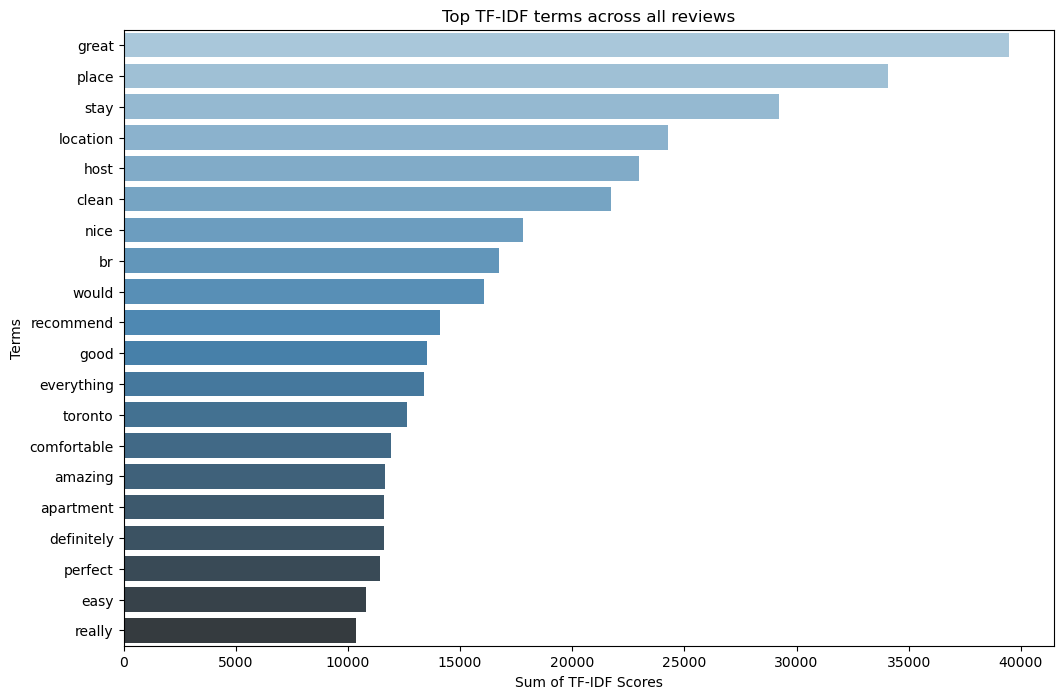

In [95]:
# TOP TF-IDF TERMS FOR THE ENTIRE CORPUS

# Sum TF-IDF scores for each term across all documents
sums = np.array(tfidf_matrix.sum(axis=0)).flatten()

# Map terms to their sums
terms = tfidf.get_feature_names_out()
data = {'Terms': terms, 'Sum_TFIDF': sums}
df_sum = pd.DataFrame(data)

# Sort and visualize top terms
top_terms = df_sum.sort_values('Sum_TFIDF', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Sum_TFIDF', y='Terms', data=top_terms, palette='Blues_d')
plt.title('Top TF-IDF terms across all reviews')
plt.xlabel('Sum of TF-IDF Scores')
plt.ylabel('Terms')
plt.show()

Next we will create word clouds for the high TF-IDF Terms. A word cloud will provide a more intuitive visualization of the most relevant words. In the visualization, the size of each term in the word cloud is proportional to its summed TF-IDF scores across all reviews. Larger terms are those that have higher relevance across the dataset.

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 325.1 kB/s eta 0:00:01
   ----------- --------------------------- 92.2/300.2 kB 521.8 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/300.2 kB 544.7 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/300.2 kB 697.2 kB/s eta 0:00:01
   ----------------------------------- -- 276.5/300.2 kB 944.1 kB/s eta 0:00:01
   -------------------------------------- 300.2/300.2 kB 926.3 kB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


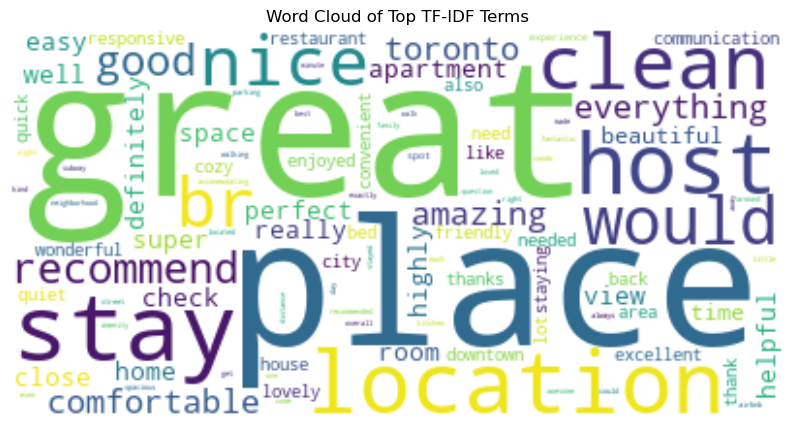

In [97]:
!pip install wordcloud
from wordcloud import WordCloud

# Generate a word cloud image for top TF-IDF terms
wordcloud = WordCloud(background_color='white', max_words=100).generate_from_frequencies(dict(zip(terms, sums)))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top TF-IDF Terms')
plt.show()

I will inspect the TF-IDF scores for specific documents now. This will help us understand why they are considered similar or important.
The visualization will show the terms with the highest TF-IDF scores in a 

Original Review Text:
<br/>g the opportunity of arriving to Alexandra's house, describes that moments when you feel blessed by God. The house is super beautiful, mega equippied, easy to mantain tidy and clean. And she and her family had been a super host. The neigbourhood is calm and pretty, and near two beautiful streets: Dundas on one side and Queen in the other. We felt very very comfortable and happy at their home. We have no more than THANKS to Alex and her family. Best stay we had ever. 
Preprocessed Text:
opportunity arriving alexandra house describes moment feel blessed god house super beautiful mega equippied easy mantain tidy clean family super host neigbourhood calm pretty near two beautiful street dundas one side queen felt comfortable happy home thanks alex family best stay ever br


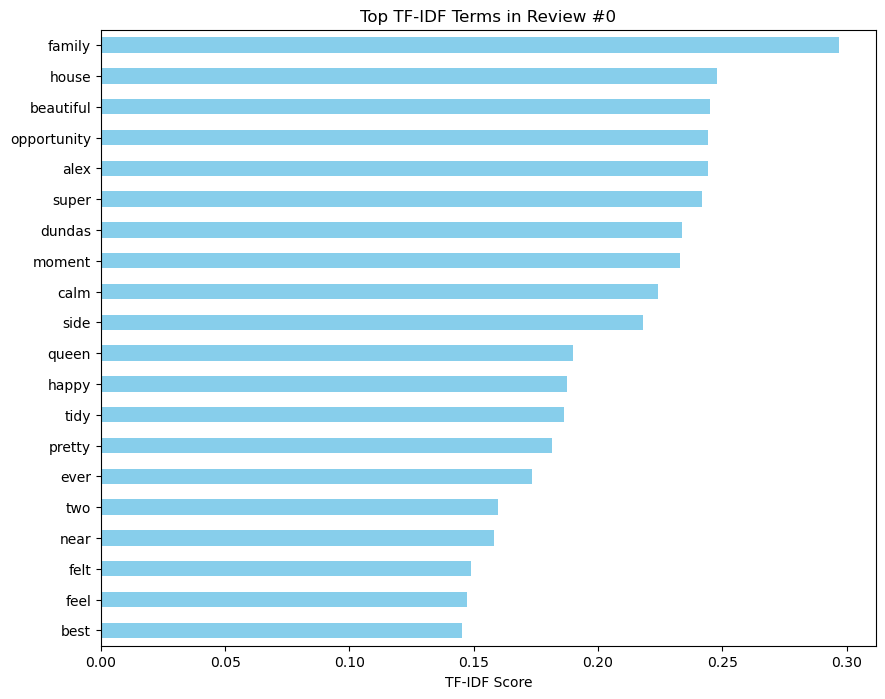

In [103]:
# Choose a document index to inspect, for example, the first document
doc_idx = 0
# Display the review
print("Original Review Text:")
print(reviews['comments'].iloc[doc_idx])
print("Preprocessed Text:")
print(reviews['cleaned_comments'].iloc[doc_idx])

# Extracting the row from the TF-IDF matrix corresponding to our document
doc_tfidf_vector = tfidf_matrix[doc_idx].toarray().flatten()

# Mapping terms to their scores
doc_terms_scores = pd.Series(doc_tfidf_vector, index=tfidf.get_feature_names_out()).sort_values(ascending=False)

# Selecting the top 20 terms with the highest TF-IDF scores
top_terms = doc_terms_scores.head(20)

# Plotting the top TF-IDF terms
plt.figure(figsize=(10, 8))
top_terms.sort_values().plot(kind='barh', color='skyblue')
plt.title(f'Top TF-IDF Terms in Review #{doc_idx}')
plt.xlabel('TF-IDF Score')
plt.show()

This visualization helps us understand which words from the specific review were weighted most heavily by the TF-IDF transformation. The terms with the highest TF-IDF scores are considered the most important in the context of the review relative to the entire corpus.
By comparing these terms with the original review text, we can get insights into why certain words are highlighted and how they might relate to the sentiment or specific aspects of the review that could influence its asociated rating or analysis. 

In terms of the TF-IDF based on lisitngs - according to what i have found, the typical approach involves concatenating all reviews for each listing into a single document and them applying the TF-IDF vectorization to these concatenated texts.

In [109]:
# Concatenate all reviews for each listing into a single text
concatenated_reviews = concatenated_reviews.set_index('listing_id').reindex(index=aggregated_reviews_df['listing_id']).reset_index()

In [117]:
# Make sure 'listing_tfidf_matrix' aligns with 'aggregated_reviews'
# Check if the 'listing_id' orders are identical:
assert (concatenated_reviews['listing_id'].values == aggregated_reviews_df['listing_id'].values).all(), "The order of listings in concatenated_reviews and aggregated_reviews does not match."

Next I will use TF-IDF vectorization at the listing level (applied to concatenated reviews). Each listings concatenated reviews is treated as a single document. This way, the TF-IDF scores will represent the importance of words in the contect of each listings combined reviews (rather than individual reviews).

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize and apply the TF-IDF vectorizer to the concatenated reviews
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  
listing_tfidf_matrix = tfidf_vectorizer.fit_transform(concatenated_reviews['cleaned_comments'])

# listing_tfidf_matrix now contains TF-IDF features for each listing

Now, lets select a subset of top features based on their average TF-IDF scores across all documents, which can be an indication of their importance

In [127]:
# Calculate average TF-IDF score for each feature
avg_scores = np.mean(listing_tfidf_matrix, axis=0)

# Get the indices of the top N features (for example, N=10)
top_n_indices = np.argsort(avg_scores)[0, -10:].tolist()[0]  # Adjust N based on your preference

# Extract these top features for each listing
top_features_matrix = listing_tfidf_matrix[:, top_n_indices]

In [104]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459355 entries, 0 to 459354
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              459355 non-null  int64         
 1   id                      459355 non-null  int64         
 2   date                    459355 non-null  datetime64[ns]
 3   reviewer_id             459355 non-null  int64         
 4   reviewer_name           459355 non-null  object        
 5   comments                459355 non-null  object        
 6   cleaned_comments        459355 non-null  object        
 7   language                459355 non-null  object        
 8   sentiment_blob          459355 non-null  float64       
 9   year                    459355 non-null  int32         
 10  review_length           459355 non-null  int64         
 11  emotions                459355 non-null  object        
 12  dominant_topic          459355

In [ ]:
Now, lets aggregate the review based features for each listing

In [ ]:
from collections import Counter

# Aggregating review features for each listing
agg_funcs = {
    'sentiment_blob': 'mean', 
    'review_length': 'mean', 
    'dominant_topic': lambda x: Counter(x).most_common(1)[0][0]
}

# Apply aggregation functions to the reviews dataframe grouped by 'listing_id'
aggregated_reviews_df= reviews.groupby('listing_id').agg(agg_funcs).reset_index()
aggregated_reviews_df.head()

In [ ]:
aggregated_reviews_df.info()

Now, lets merge the aggregated_reviews with the listings dataset and build our model

In [32]:
listings = pd.read_csv("http://data.insideairbnb.com/canada/on/toronto/2024-01-08/data/listings.csv.gz")

In [115]:
# Merge the necessary 'ratings' from 'listings' with the 'aggregated_reviews'.
merged_data = pd.merge(aggregated_reviews_df, listings[['id', 'review_scores_rating']], left_on='listing_id', right_on='id', how='left')

# Drop any rows with missing target values as they cannot be used for training
merged_data.dropna(subset=['review_scores_rating'], inplace=True)

merged_data.head()

,listing_id,sentiment_blob,review_length,dominant_topic,id,review_scores_rating
0,1419,0.430815,66.333333,3,1419,5.00
1,8077,0.476099,56.904192,0,8077,4.84
2,26654,0.408193,49.666667,1,26654,4.79
3,27423,0.415231,75.925926,1,27423,4.93
4,30931,0.396429,42.000000,3,30931,5.00


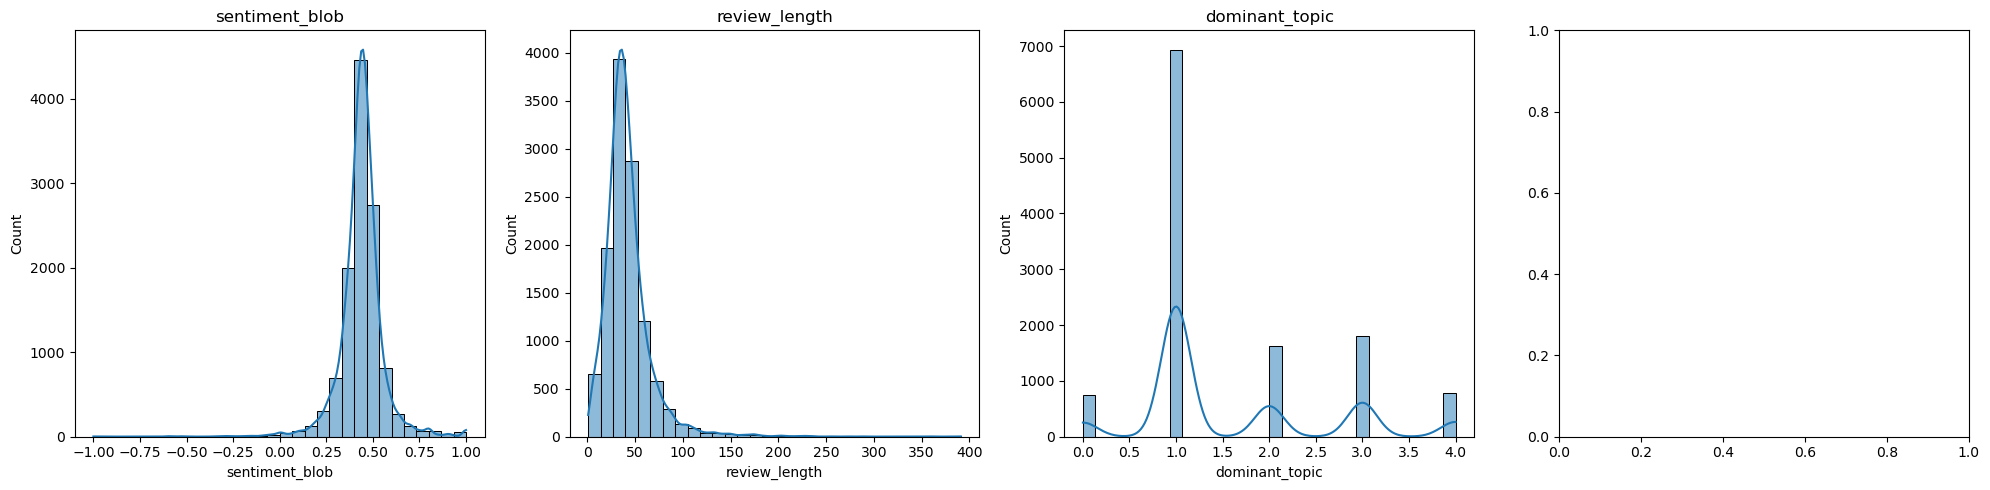

In [72]:
# Select a few numerical columns to visualize
sample_num_cols = num_cols[:4]  # Change this based on your dataset

# Plot distributions before scaling
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, col in zip(axes, sample_num_cols):
    sns.histplot(X_train[col], bins=30, kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()


In [69]:
cat_cols = [col for col in merged_data.columns if merged_data[col].dtype == 'object']

# Visualize the first few categorical features due to space limitations
for col in cat_cols[:4]:  # Adjust based on your actual number of categorical columns
    plt.figure(figsize=(10, 4))
    sns.countplot(y=col, data=merged_data)
    plt.title(f'Distribution of {col}')
    plt.show()

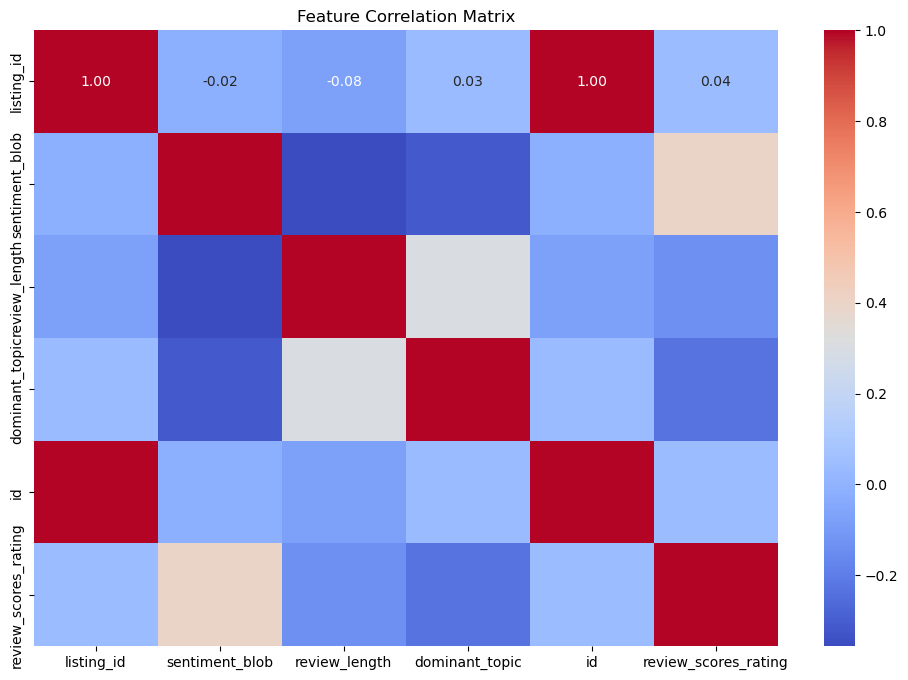

In [58]:
# Calculate correlations
corr_matrix = merged_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [65]:
# SELECT FEATURES AND TARGET VARIABLE & SPLIT DATA

# Define features and target variable
X = merged_data.drop(columns=['listing_id', 'id', 'review_scores_rating'])  # Drop non-features and target variable
y = merged_data['review_scores_rating']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

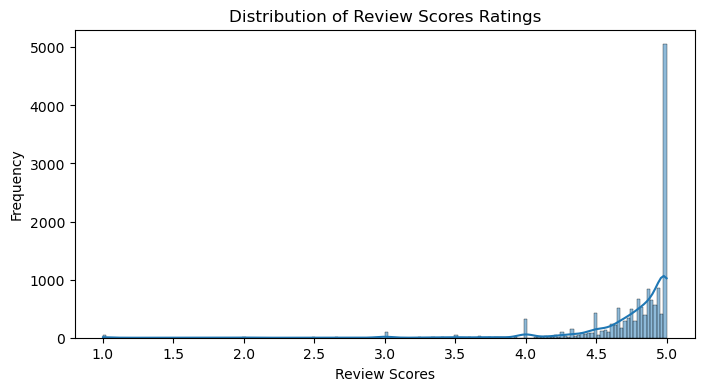

In [78]:
# Visualization of Target Variable
plt.figure(figsize=(8,4 ))
sns.histplot(y, kde=True)
plt.title('Distribution of Review Scores Ratings')
plt.xlabel('Review Scores')
plt.ylabel('Frequency')
plt.show()

Next step, we will set up preprocessing steps for the data, which would include scaling numerical features and and filling missing values with the median.
These steps are bundled with a RandomForestRegressor in a pipeline, streamlining preprocessing and modeling.

In [81]:
# PREPROCESSING AND PIPLELINE SETUP

# Numeric features preprocessing
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Create the modeling pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

Next we fit the pipeline to the training data. This trains the RandomForestRegressor on the preprocessed training data, learning to predict the review scores.

In [82]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['sentiment_blob', 'review_length', 'dominant_topic'], dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

After training, we will visualiza which features are most influential in our model. The bar chart shows the importance of each feature used by the model to predict review scores, helping us understand which features have the most impact.

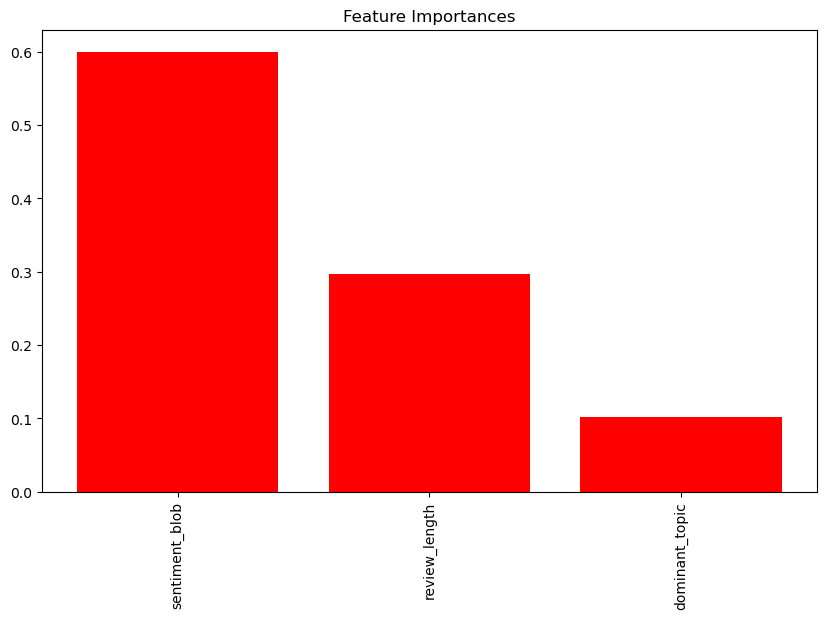

In [83]:
importances = pipeline.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.show()

Finally, we evaluate the models performance on the test set and visualize the prediction accuracy.
The scatter plot and regression line between actual and predicted ratings visually demonstrate the model's accuracy.
Points closer to the line represent more accurate predictions.
The Mean Squared Error(MSE) and R² provide numerical measures of the model's performance, with R² indicating the proportion of variance in the target variable explained by the model.

Mean Squared Error: 0.11803522335318628
R^2 Score: 0.25811134884782494


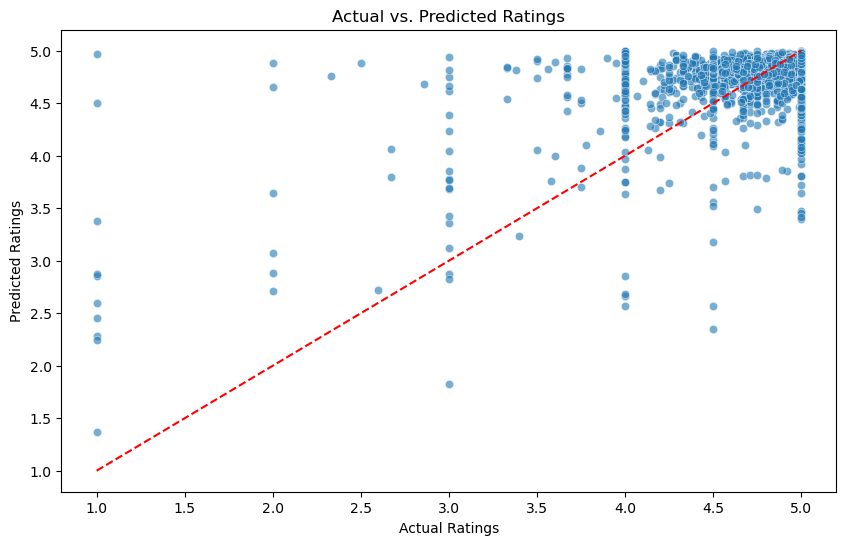

In [85]:
from sklearn.metrics import mean_squared_error, r2_score

# Making predictions with the trained pipeline
y_pred = pipeline.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Visualization: Actual vs. Predicted Ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()

It appears this model doesn't do that well, next we so lets try a different approach

Instead of looking at each review individually first, we will look at all the reviews of a listing together. 
This way, when text analysis or feature extraction is performed, each listing is viewed as one document

In [143]:
all_reviews = reviews.groupby('listing_id')['cleaned_comments'].apply(' '.join).reset_index()
all_reviews.head()

,listing_id,cleaned_comments
0,1419,opportunity arriving alexandra house describes...
1,8077,lovely time toronto kathie larry great host wa...
2,26654,friend absolutely loved stay apartment locatio...
3,27423,family really enjoyed stay brent apartment tor...
4,30931,fabulous accomodation matched view superceeded...


In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer

all_reviews_tfidf_vectorizer = TfidfVectorizer(max_features=1000)
all_reviews_tfidf_matrix = all_reviews_tfidf_vectorizer.fit_transform(all_reviews['cleaned_comments'])  


In [145]:
# Convert TF-IDF matrix to DataFrame for merging
all_reviews_tfidf_features_df = pd.DataFrame(all_reviews_tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(all_reviews_tfidf_matrix.shape[1])])
all_reviews_tfidf_features_df['listing_id'] = all_reviews['listing_id'].values

# Merge with the ratings from listings
ratings = listings[['id', 'review_scores_rating']].rename(columns={'id': 'listing_id'})  # Ensure column names match for merging
reviews_ratings = pd.merge(all_reviews_tfidf_features_df, ratings, on='listing_id', how='left')


In [149]:
from sklearn.model_selection import train_test_split

X2 = reviews_ratings.drop(['listing_id', 'review_scores_rating'], axis=1)
y2 = reviews_ratings['review_scores_rating']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [150]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train2, y_train2)

RandomForestRegressor(random_state=42)

In [151]:
y_pred2 = model.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
r2_2 = r2_score(y_test2, y_pred2)

print(f"Mean Squared Error: {mse2}")
print(f"R^2 Score: {r2_2}")

Mean Squared Error: 0.11061885264251323
R^2 Score: 0.30472558065659805


The current model uses a TF-IDF representation of the review texts and a Random Forest Regressor to predict the ratings. 

The current model could be improved in a few ways:

Hyperparameter Tuning - use grid search or random search to find the optimal set of hyperparameters for the Random Forest model. This could include adjusting the number of estimators, max depth, min samples split, min samples leaf, and max features.

Feature Selection - use techniques like Recursive Feature Elimination (RFE) or feature importance scores from the Random Forest model to identify and keep the most informative features.

Extend TF-IDF Features - consider increasing 'max_features' in the 'TfidfVectorizer' or tweaking other parameters like 'min_df' and 'max_df'. Also, experimenting with different n-gram ranges might capture more contextual infomration.

Text Preprocessing - further refine the text preprocessing. Consider additional steps like lemmatization, handling negations, and removing or including certain types of words (eg proper nouns, less frequent words)

OTHER MODELS that could be used

1. Linear models - given the sparse nature of TF-IDF matrices, linear models like Ridge Regression or Lasso Regression can be effective and provide faster training times compared to Random Forest

2. Gradient Boosting MAchines - models like Gradient Boosting Regressor or XGBoost can provide better performance through ensemble learning of decision trees

3. Support Vector Machines - SVMs can be effective for high-dimesntional data, like TF-IDF vectors. Perhaps using SVR (Suppor Vector Regression)

4. Neural Networks - if there is enough data, neural networks, especially those designed for NLP tasks like Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs), can capture complex relationships in text.
- Depending on the computing resources, experimenting with pre-trained models like BERT or transformers, adapted for regression tasks, can significantly improve results but requires more computational power.

Additional Improvements:

Ensemble Methods: Combine predictions from multiple models through techniques like stacking or averaging to potentially improve performance and reduce overfitting.

Cross-validation: Instead of a single train-test split, use k-fold cross-validation to evaluate model performance more robustly.

Sentiment and Emotion Features: Incorporate the sentiment and emotion scores as additional features alongside the TF-IDF vectors to provide the models with more contextual information.

By experimenting with these different models and techniques, you can identify what works best for your particular dataset and potentially improve the accuracy of your predictions. Always monitor changes in performance metrics to ensure improvements are meaningful and not just due to random variation.